# Modelos de regresión (reentrega)

El fin de este notebook es usar las ideas de `eda-reentrega.ipynb` para diseñar un modelo de regresión que nos permita explicar las características de la expectativa de vida.

Como primer paso vamos a importar las bibliotecas a utilizar y definir algunas funciones que nos van a ser de ayuda:

In [1]:
!make -C .. metnum.so
!cp ../metnum.so metnum.so

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from metnum import least_squares
from IPython.display import display, Markdown

make: se entra en el directorio '/home/iglosiggio/facu/metodos/labos/tp3'
make: 'metnum.so' está actualizado.
make: se sale del directorio '/home/iglosiggio/facu/metodos/labos/tp3'


In [2]:
def start_print_capture():
    global print
    real_print = print
    captured = ''
    
    def fake_print(v):
        nonlocal captured
        captured += v + '\n'

    print = fake_print

    def stop_capture():
        global print
        print = real_print
        display(Markdown(captured))

    return stop_capture

def normalizar(M):
    return (M - np.mean(M)) / np.std(M)

def TSS(B):
    return np.sum((B - np.mean(B))**2)

def RSS(A, X, B):
    return np.sum((B - A @ X)**2)

def R2(RSS, TSS):
    return (TSS - RSS) / TSS

def R2_ajustado(R2, N, p):
    return 1 - (1 - R2)*(N - 1)/(N - p - 1)

def leverage(X):
    X = np.array(X)
    return np.diag(X @ np.linalg.inv((X.T @ X)) @ X.T)

def residual_plot(A, X, B):
    leverage_score = leverage(A)
    predicted = A @ X
    residual = B - predicted
    plt.scatter(predicted, residual, s=9, c=leverage_score)
    plt.xlabel("Predicciones")
    plt.ylabel("Residuos")
    plt.hlines(0, xmin=min(predicted), xmax=max(predicted))
    plt.colorbar()
    plt.title("Residual plot")
    return plt

def probar_modelo(param_A):
    display_markdown = start_print_capture()
    A = param_A.copy()
    print('### Resultados')
    print(f'Se evaluó un modelo con {len(A.columns)} features (más el término constante)')
    # Normalizamos A
    #A = normalizar(A)
    # Agregamos una columna para el término constante
    A['k'] = 1
    B = df['Life expectancy']
    #B = normalizar(B)
    N = len(A)
    p = len(A.columns)
    X = least_squares(A, B)
    tss = TSS(B)
    rss = RSS(A, X, B)
    r2 = R2(rss, tss)
    r2_ajustado = R2_ajustado(r2, N, p)
    leverage_score = leverage(A)
    mean_leverage = leverage_score.mean()
    print('#### Métricas')
    print(f'- **TSS:** {tss}')
    print(f'- **RSS:** {rss}')
    print(f'- **R^2:** {r2}')
    print(f'- **R^2 ajustado:** {r2_ajustado}')
    print(f'- **Mean leverage:** {mean_leverage}')
    print(f'- **Maybe outliers:**')
    print(f'  * Rows with leverage over two times the mean: {sum(1 for row_leverage in leverage_score if row_leverage > 2 * mean_leverage)}')
    print(f'  * Rows with leverage over three times the mean: {sum(1 for row_leverage in leverage_score if row_leverage > 3 * mean_leverage)}')
    print('#### Coeficientes de X')
    for (col, coeff) in zip(A.columns, X):
        print(f'- **{col}:** _{coeff}_')
    print('#### Aporte esperado de cada variable')
    pais_promedio = A.mean()
    for col_idx, col in enumerate(A.columns):
        print(f'- **{col}:** {X[col_idx] * pais_promedio[col]}')
    vif(param_A)
    plt = residual_plot(A, X, B)
    plt.show()
    display_markdown()
    #return A, X, B

def vif(M):
    columns = list(M.columns)
    # Normalizamos todo
    #M = normalizar(M)
    print('#### VIF')
    for column in columns:
        A = M[[col for col in M.columns if col != column]]
        B = M[column]
        X = least_squares(A, B)
        tss = TSS(B)
        rss = RSS(A, X, B)
        r2 = R2(rss, tss)
        print(f'- **{column}**: {1/(1 - r2)}')

df = pd.read_csv('../data/dataset-completado.csv')
df.columns

Index(['Unnamed: 0', 'Country', 'Life expectancy', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles', 'BMI', 'under-five deaths', 'Polio', 'Total expenditure',
       'Diphtheria', 'HIV/AIDS', 'GDP', 'Population', 'thinness  1-19 years',
       'thinness 5-9 years', 'Income composition of resources', 'Schooling',
       'Status', 'Estimated road traffic death rate',
       'Age-standardized suicide rates',
       'Population using safely managed drinking-water services (%)',
       'Population using safely managed sanitation services (%)', 'Region'],
      dtype='object')

Con esto ahora podemos empezar a evaluar distintos modelos, carguemos los datos e intentemos algo muy tonto:

## Primer modelo: Usar sólo las variables categóricas

Como primer modelo (ultra simplista) consideramos usar sólo las variables categóricas. Suponemos de primera mano que este es un modelo _"malo"_ pero sencillo, un problema interesante es el de  modelar el feature de regiones (es decir, traducir al nombre de la región por un número). Para esto decidimos numerarlos en orden creciente de la región con menor expectativa de vida promedio a la de mayor expectativa de vida promedio.

,Life expectancy
Region,
Africa,57.417952
South-East Asia,68.644318
Eastern Mediterranean,69.800893
Western Pacific,72.195833
Americas,73.485417
Europe,76.149625


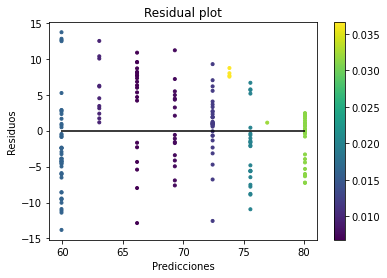

### Resultados
Se evaluó un modelo con 2 features (más el término constante)
#### Métricas
- **TSS:** 15359.076092896175
- **RSS:** 6105.662020217091
- **R^2:** 0.6024720508389786
- **R^2 ajustado:** 0.5958095712441012
- **Mean leverage:** 0.016393442622950817
- **Maybe outliers:**
  * Rows with leverage over two times the mean: 4
  * Rows with leverage over three times the mean: 0
#### Coeficientes de X
- **int_status:** _4.518040958540629_
- **int_region:** _3.1264636093298908_
- **k:** _56.80034683810407_
#### Aporte esperado de cada variable
- **int_status:** 0.790039949034427
- **int_region:** 11.634544906850577
- **k:** 56.80034683810407
#### VIF
- **int_status**: 1.218640164988835
- **int_region**: 0.32207653230236316


In [3]:
avg_life_expectancy_per_region = df.groupby('Region')[['Region', 'Life expectancy']].mean().sort_values(by='Life expectancy')
display(avg_life_expectancy_per_region)
region_int_mapping = {
    region: idx + 1
    for idx, region
    in enumerate(avg_life_expectancy_per_region.reset_index().Region)
}
df['int_status'] = df['Status'].apply(lambda x: 0 if x=='Developing' else 1)
df['int_region'] = df['Region'].apply(lambda x: region_int_mapping[x])
probar_modelo(df[['int_status', 'int_region']])

Como era de esperarse el residualplot no está muy bueno...

Dado que para una combinación `(Región, Estado)` sólo obtenemos un resultado observamos estas líneas verticales que representan cada una de las combinaciones. Es interesante notar que pese a tener seis regiones y dos estados sólo se observan nueve rectas verticales, es decir: hay regiones sin países desarrollados.

Para varias de las rectas vemos dos grupos distinguidos. Conjeturamos que estos nos podría dar pié para justificar una clasificación intermedia entre "país desarrollado" y "país en vías de desarrollo", pero no ahondaremos mucho más en esto.

Sobre los resultados observado tenemos algo de poder predictivo y podemos notar un par de cosas sobre los coeficientes de X:
* La región del país aumenta más (en promedio) al resultado que el estado
* Nuestras predicciones parten de al menos 56 años

## Agregando variables no categóricas: Acceso al agua potable

Cómo vimos en el análisis exploratorio de datos la proporción de gente con acceso a agua potable mantiene una alta correlación con la expectativa de vida. Es por esto que es una de las primeras variables que queremos considerar. Vale la pena apreciar que considerar Adult Mortality (la variable de mayor correlación) sería tonto si buscáramos que el modelo nos permita explicar las predicciones, dado que "cuánto mucha gente se muere antes de los 60 años entonces baja la expectativa de vida del país" no es información relevante.

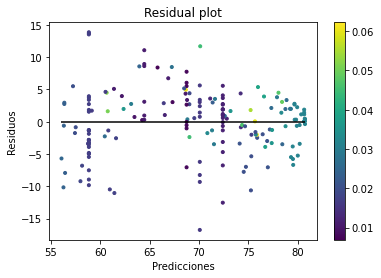

### Resultados
Se evaluó un modelo con 3 features (más el término constante)
#### Métricas
- **TSS:** 15359.076092896175
- **RSS:** 4416.369490668198
- **R^2:** 0.712458648947586
- **R^2 ajustado:** 0.7059970455531498
- **Mean leverage:** 0.02185792349726774
- **Maybe outliers:**
  * Rows with leverage over two times the mean: 11
  * Rows with leverage over three times the mean: 0
#### Coeficientes de X
- **int_status:** _1.3807143036007_
- **int_region:** _1.161755756501849_
- **Population using safely managed drinking-water services (%):** _0.18495393063562804_
- **k:** _53.87763434072084_
#### Aporte esperado de cada variable
- **int_status:** 0.24143638095749945
- **int_region:** 4.323255028293766
- **Population using safely managed drinking-water services (%):** 10.782605944016955
- **k:** 53.87763434072084
#### VIF
- **int_status**: 1.2860256518972517
- **int_region**: 2.7459872164284636
- **Population using safely managed drinking-water services (%)**: 2.713998982971346


In [4]:
probar_modelo(df[['int_status', 'int_region', 'Population using safely managed drinking-water services (%)']])

Vemos entonces un aumento importante en la varianza explicada por este nuevo modelo. A éste se le suma un aumento a la multicolinearidad (esperable dado que el acceso al agua potable es un problema endémico en ciertas regiones).

### Expandiendo el modelo: Escolaridad y accidentes de tránsito

Un detalle súper interesante de la regresión lineal es que añadir variables no disminuye $R^2$ (dado que en el peor de los casos la solución de cuadrados mínimos asigna el coeficiente $0$ a la nueva variable. Elegimos entonces eliminar el estado del país y reemplazarlo por la cantidad estimada de muertes por accidentes de tránsito y la cantidad de años de escolaridad. Las fueron en parte elegidas por la baja colinearidad entre ellas observada en el análisis.

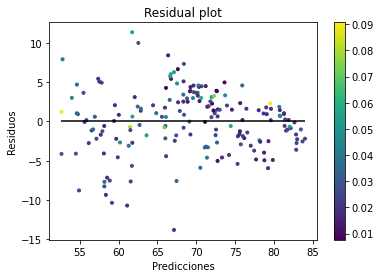

### Resultados
Se evaluó un modelo con 4 features (más el término constante)
#### Métricas
- **TSS:** 15359.076092896175
- **RSS:** 2824.0008483330553
- **R^2:** 0.8161347185694847
- **R^2 ajustado:** 0.8109407840657978
- **Mean leverage:** 0.027322404371584612
- **Maybe outliers:**
  * Rows with leverage over two times the mean: 14
  * Rows with leverage over three times the mean: 2
#### Coeficientes de X
- **int_region:** _0.046120372718816194_
- **Population using safely managed drinking-water services (%):** _0.135074286586915_
- **Estimated road traffic death rate:** _-0.31233039108412974_
- **Schooling:** _0.9052306894487305_
- **k:** _56.04158650691574_
#### Aporte esperado de cada variable
- **int_region:** 0.17162827224870944
- **Population using safely managed drinking-water services (%):** 7.874678848027467
- **Estimated road traffic death rate:** -5.716538986543595
- **Schooling:** 10.853577053340743
- **k:** 56.04158650691574
#### VIF
- **int_region**: 3.2929508967992382
- **Population using safely managed drinking-water services (%)**: 3.3703452476146003
- **Estimated road traffic death rate**: 0.6710863653578375
- **Schooling**: 1.2498392978197284


In [5]:
probar_modelo(df[['int_region', 'Population using safely managed drinking-water services (%)', 'Estimated road traffic death rate', 'Schooling']])

La variable categórica y la que mide % de la población con acceso al agua potable aumentaron considerablemente la colinearidad. Pese a esto el modelo se ve bastante útil. Decidimos entonces reemplazar ese % por otra de las variables del dataset (con la esperanza de que explique mejor los datos). La elegida fueron las muertes infantiles relacionadas con casos de SIDA.

### Primer modelo sin variables categóricas

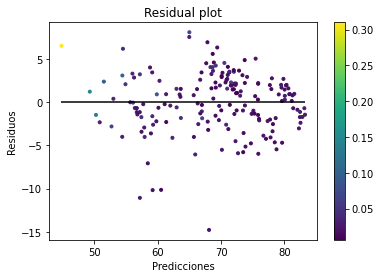

### Resultados
Se evaluó un modelo con 4 features (más el término constante)
#### Métricas
- **TSS:** 15359.076092896175
- **RSS:** 2138.8111697823115
- **R^2:** 0.8607461049840396
- **R^2 ajustado:** 0.8568123791361311
- **Mean leverage:** 0.027322404371584598
- **Maybe outliers:**
  * Rows with leverage over two times the mean: 13
  * Rows with leverage over three times the mean: 7
#### Coeficientes de X
- **Population using safely managed drinking-water services (%):** _0.10577238284288337_
- **Estimated road traffic death rate:** _-0.21147705394074223_
- **Schooling:** _1.0954599134123035_
- **HIV/AIDS:** _-0.5177079525724146_
- **k:** _54.6995634786433_
#### Aporte esperado de cada variable
- **Population using safely managed drinking-water services (%):** 6.166410846392762
- **Estimated road traffic death rate:** -3.8706346168087125
- **Schooling:** 13.134396256833721
- **HIV/AIDS:** -0.9048042710720007
- **k:** 54.6995634786433
#### VIF
- **Population using safely managed drinking-water services (%)**: 2.4415549534326626
- **Estimated road traffic death rate**: 0.7270584372086636
- **Schooling**: 1.0749734749210493
- **HIV/AIDS**: 1.3917802188375683


In [13]:
probar_modelo(df[['Population using safely managed drinking-water services (%)', 'Estimated road traffic death rate', 'Schooling', 'HIV/AIDS']])

Notamos un gran aumento del R2 sumado a esto los residuos están casi todos entre 5 y -5. ¡Un montón de progreso!

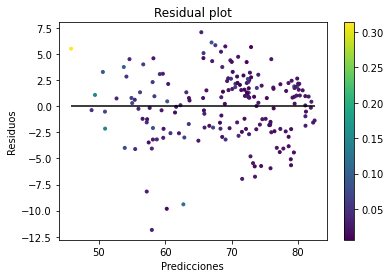

### Resultados
Se evaluó un modelo con 5 features (más el término constante)
#### Métricas
- **TSS:** 15359.076092896175
- **RSS:** 1839.0026596981545
- **R^2:** 0.8802660623220219
- **R^2 ajustado:** 0.8761842235375453
- **Mean leverage:** 0.032786885245901676
- **Maybe outliers:**
  * Rows with leverage over two times the mean: 17
  * Rows with leverage over three times the mean: 5
#### Coeficientes de X
- **Population using safely managed drinking-water services (%):** _0.08585644542086707_
- **Estimated road traffic death rate:** _-0.2034386436780351_
- **Schooling:** _0.9148234495220666_
- **HIV/AIDS:** _-0.5276234557204627_
- **Diphtheria:** _0.10185764000036102_
- **k:** _49.525903299602774_
#### Aporte esperado de cada variable
- **Population using safely managed drinking-water services (%):** 5.005334115072212
- **Estimated road traffic death rate:** -3.723508730348884
- **Schooling:** 10.968592774552723
- **HIV/AIDS:** -0.9221337124174604
- **Diphtheria:** 8.370743947527718
- **k:** 49.525903299602774
#### VIF
- **Population using safely managed drinking-water services (%)**: 2.644955497993444
- **Estimated road traffic death rate**: 0.9792710196031865
- **Schooling**: 1.935336049631455
- **HIV/AIDS**: 1.392832042317629
- **Diphtheria**: 1.292833639429251


In [8]:
probar_modelo(df[['Population using safely managed drinking-water services (%)', 'Estimated road traffic death rate', 'Schooling', 'HIV/AIDS', 'Diphtheria']])

Logramos un mejor resultado, pero el numero de variables se volvio bastante alto. 
¿Que pasa si siguimos agregando features?

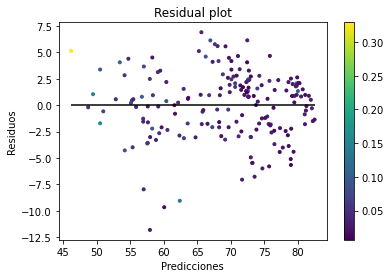

### Resultados
Se evaluó un modelo con 6 features (más el término constante)
#### Métricas
- **TSS:** 15359.076092896175
- **RSS:** 1830.4034304273634
- **R^2:** 0.8808259416545273
- **R^2 ajustado:** 0.8760589793207084
- **Mean leverage:** 0.038251366120218636
- **Maybe outliers:**
  * Rows with leverage over two times the mean: 16
  * Rows with leverage over three times the mean: 4
#### Coeficientes de X
- **Population using safely managed drinking-water services (%):** _0.08546339044273046_
- **Estimated road traffic death rate:** _-0.20881611373539533_
- **Schooling:** _0.8890035339992028_
- **HIV/AIDS:** _-0.5229538495662992_
- **Diphtheria:** _0.06443488278760182_
- **Polio:** _0.04349245253429834_
- **k:** _49.440578310302115_
#### Aporte esperado de cada variable
- **Population using safely managed drinking-water services (%):** 4.982419452328815
- **Estimated road traffic death rate:** -3.8219318044697443
- **Schooling:** 10.659015949656506
- **HIV/AIDS:** -0.9139725868803359
- **Diphtheria:** 5.295311231460538
- **Polio:** 3.583511141591171
- **k:** 49.440578310302115
#### VIF
- **Population using safely managed drinking-water services (%)**: 2.647149378088939
- **Estimated road traffic death rate**: 1.0431544557941383
- **Schooling**: 2.0969728421507803
- **HIV/AIDS**: 1.403136788818752
- **Diphtheria**: 9.543730797890936
- **Polio**: 10.222765571197286


In [9]:
probar_modelo(df[['Population using safely managed drinking-water services (%)', 'Estimated road traffic death rate', 'Schooling', 'HIV/AIDS', 'Diphtheria', 'Polio']])

Notamos que agregando Polio comienza a disminuir el R2 ajustado. Como Polio y Diphtheria tienen una correlacion muy alta entre si esto tiene sentido. Probamos con 'Age-standardized suicide rates', tiene poca correlacion con la expectativa de vida, pero tambien la tiene con las otras variables por lo que podria sumar.

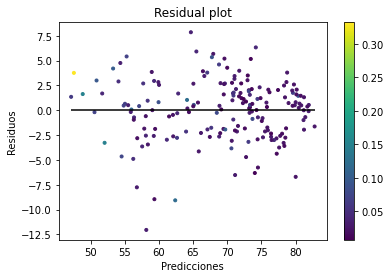

### Resultados
Se evaluó un modelo con 6 features (más el término constante)
#### Métricas
- **TSS:** 15359.076092896175
- **RSS:** 1670.323387801402
- **R^2:** 0.8912484463454183
- **R^2 ajustado:** 0.8868983841992351
- **Mean leverage:** 0.03825136612021863
- **Maybe outliers:**
  * Rows with leverage over two times the mean: 15
  * Rows with leverage over three times the mean: 5
#### Coeficientes de X
- **Population using safely managed drinking-water services (%):** _0.08255729949277461_
- **Estimated road traffic death rate:** _-0.18223042291997826_
- **Schooling:** _0.9944872524206712_
- **HIV/AIDS:** _-0.46328775353555685_
- **Diphtheria:** _0.09792226788376446_
- **Age-standardized suicide rates:** _-0.1329836940903392_
- **k:** _50.145624287862475_
#### Aporte esperado de cada variable
- **Population using safely managed drinking-water services (%):** 4.812997621480675
- **Estimated road traffic death rate:** -3.335337664517515
- **Schooling:** 11.923749546412393
- **HIV/AIDS:** -0.8096934498522902
- **Diphtheria:** 8.04733185663151
- **Age-standardized suicide rates:** -1.559740504028176
- **k:** 50.145624287862475
#### VIF
- **Population using safely managed drinking-water services (%)**: 2.657530885234871
- **Estimated road traffic death rate**: 1.046922072605365
- **Schooling**: 2.0335709261079296
- **HIV/AIDS**: 1.474824198500218
- **Diphtheria**: 1.2930766533292302
- **Age-standardized suicide rates**: 1.1708505358029886


In [10]:
probar_modelo(df[['Population using safely managed drinking-water services (%)', 'Estimated road traffic death rate', 'Schooling', 'HIV/AIDS', 'Diphtheria', 'Age-standardized suicide rates']])

Se logro una gran mejora, habria que ver si puede descartarse alguna variable sin modificar notablemente el resultado